# Explore differential expression analysis results

In [1]:
import os,sys
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import pymde
import hdbscan
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import timeit

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)

In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

## Read best DE results, filter based on number of DE genes and correlations with other perturbations

In [3]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [ ]:
a

In [4]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

In [8]:
adata_de[adata_de.obs.target_contrast_gene_name=='C7orf26'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target
ENSG00000146576_Stim8hr,C7orf26,Stim8hr,ENSG00000146576,222,201.0
ENSG00000146576_Rest,C7orf26,Rest,ENSG00000146576,317,154.0
ENSG00000146576_Stim48hr,C7orf26,Stim48hr,ENSG00000146576,462,225.0


In [5]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)

In [9]:
de_summary_stats[de_summary_stats.target_name=='ARHGAP27']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
7267,ENSG00000159314,ARHGAP27,Stim48hr,201.0,68,8,76,-6.550189,True,29.924287,False,>10 DE genes,on-target KD
30197,ENSG00000159314,ARHGAP27,Stim8hr,234.0,709,225,934,-6.386096,True,23.812385,False,>10 DE genes,on-target KD
33364,ENSG00000159314,ARHGAP27,Rest,239.0,4,5,9,-8.555445,True,39.534745,False,2-10 DE genes,on-target KD


In [8]:
mask = (de_counts.n_total_de_genes>30) & (de_counts.n_cells_target>75)
adata_de_filtered = adata_de[mask].copy()
adata_de_filtered.var_names = adata_de_filtered.var.gene_name
adata_de_filtered.X = np.nan_to_num(adata_de_filtered.layers['zscore'], 0)

In [9]:
adata_de_filtered.write_h5ad('../../../RZAnalysisCodes/results/adata_de_de30ntotal75.h5ad')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(np.sort(np.abs(adata_de_filtered.X).sum(0)), '.')

In [11]:
adata_de_filtered = adata_de_filtered[:,np.abs(adata_de_filtered.X).sum(0)>2000].copy()

In [12]:
adata_de_filtered

AnnData object with n_obs × n_vars = 4675 × 10759
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [13]:
adata_de_filtered.write_h5ad('../../../RZAnalysisCodes/results/adata_de_de30ntotal75_filtered.h5ad')

### Simple PCA clustering

In [14]:
adata = adata_de_filtered.copy()
sc.pp.scale(adata)

In [15]:
sc.pp.pca(adata, n_comps=300)

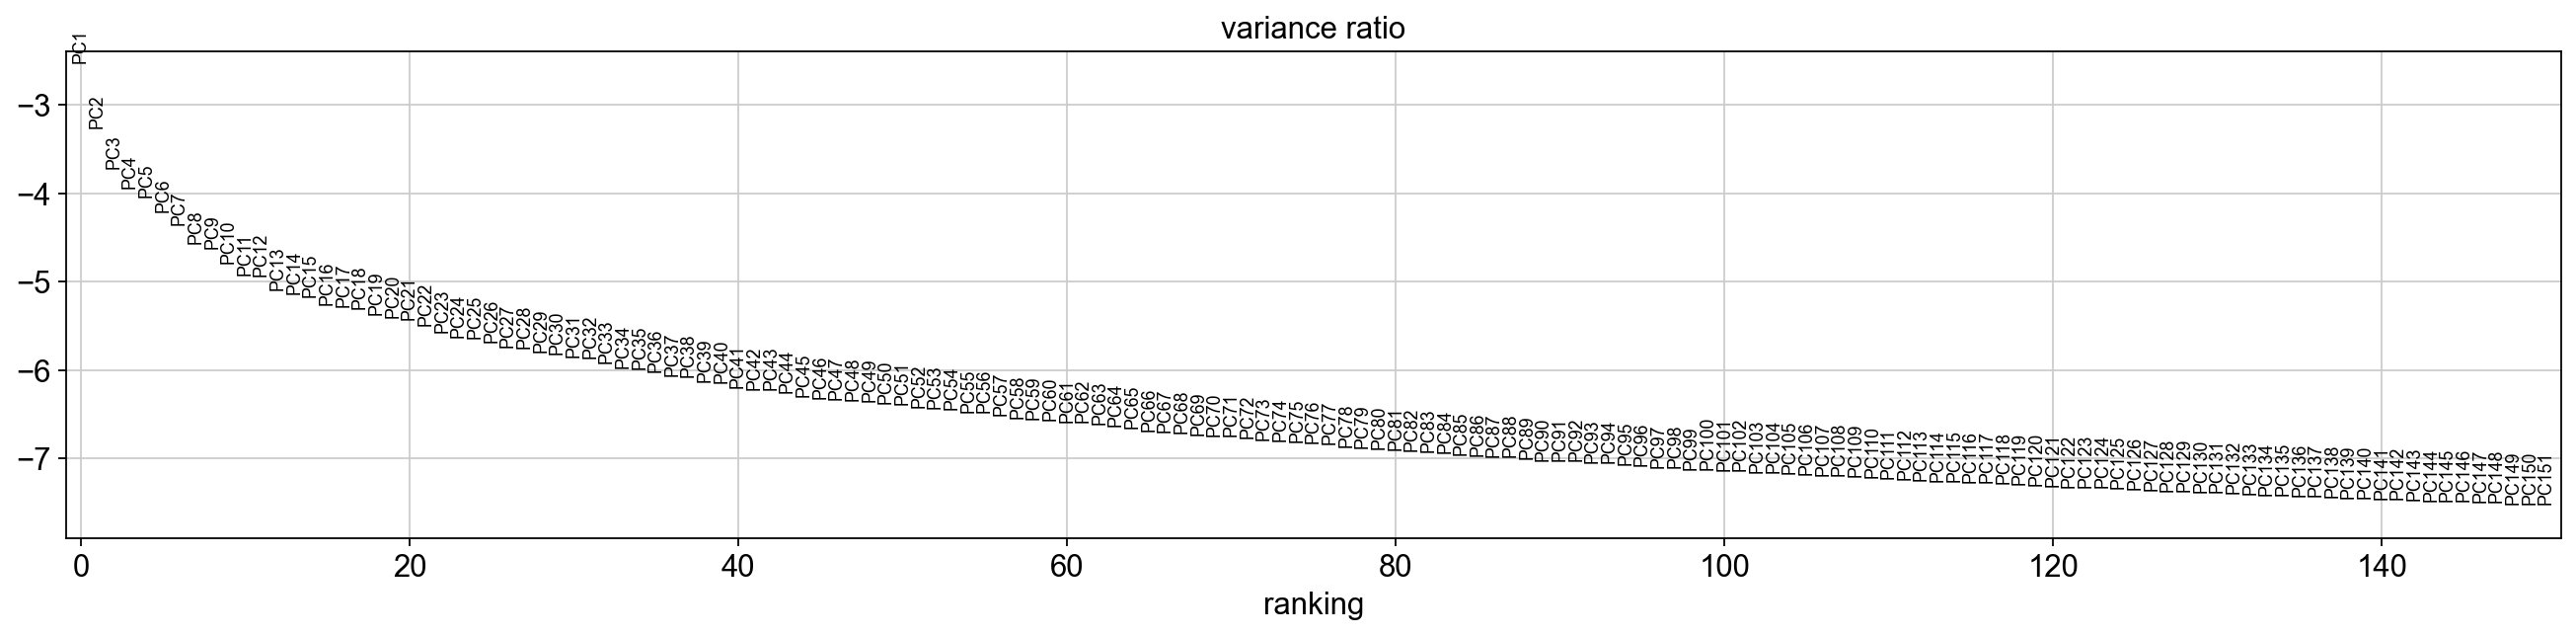

In [16]:
sc.set_figure_params(figsize=(20, 4))
sc.pl.pca_variance_ratio(adata, n_pcs=150, log=True)

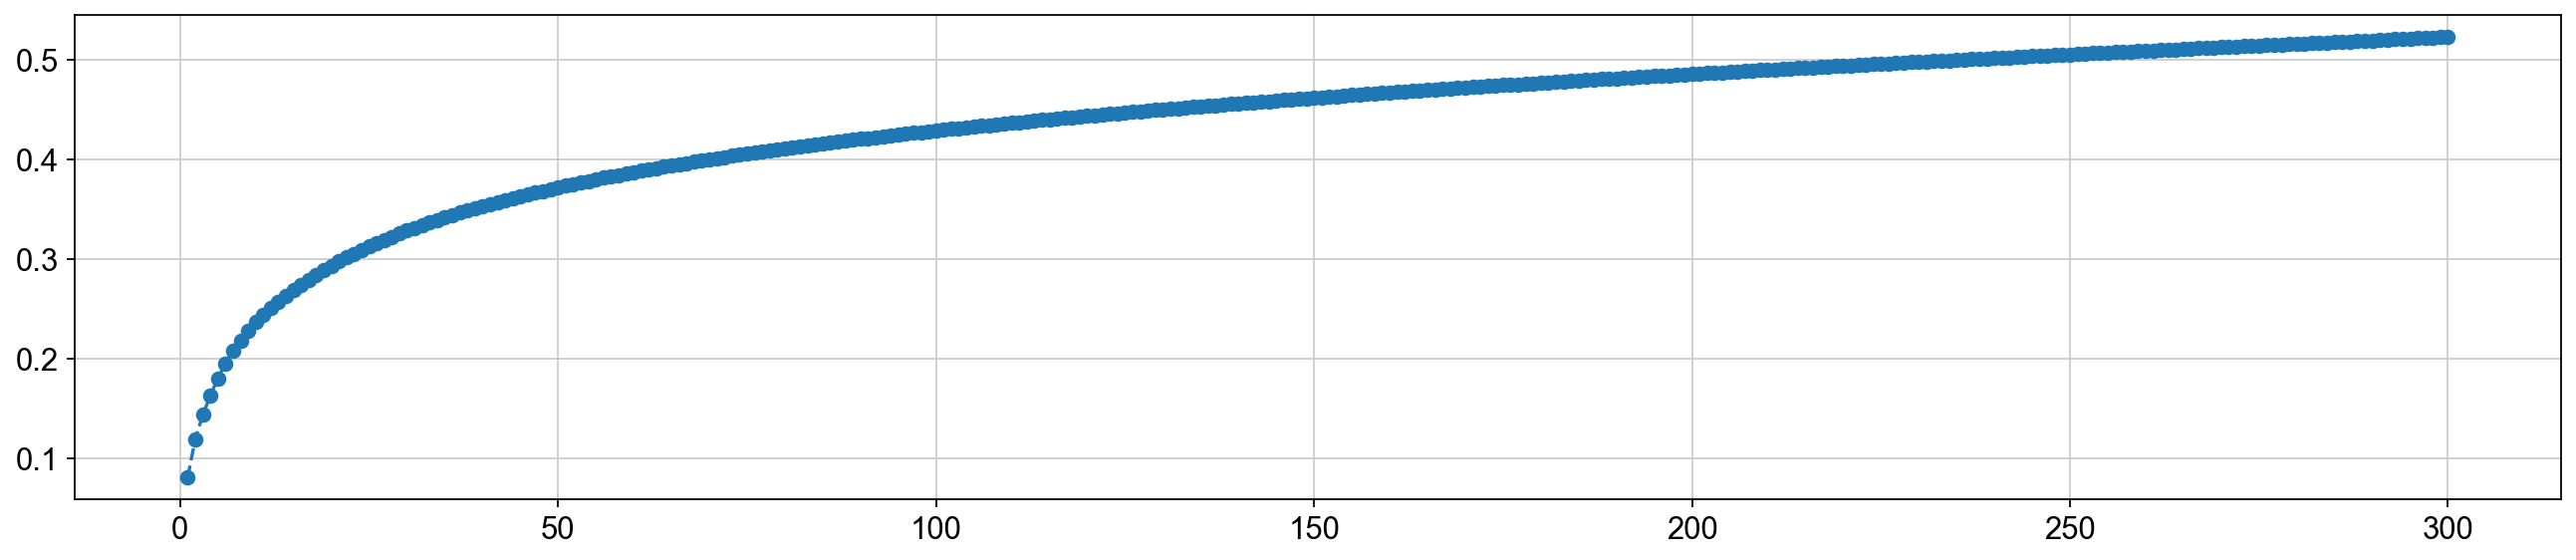

In [17]:
variance_ratio = adata.uns['pca']['variance_ratio']
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')

In [18]:
n_comp_all = [75, 100, 150, 250]
n_neighbor_all = [15, 31, 63]
resolution_all = [2, 3, 4]
clustering_all = []
for n_comp in n_comp_all:
    for n_neighbor in n_neighbor_all:
        sc.pp.neighbors(adata, n_pcs=n_comp, n_neighbors=n_neighbor, random_state=42)
        print(f'{n_comp} {n_neighbor}')
        for resolution in resolution_all:
            sc.tl.leiden(adata, resolution=resolution, random_state=42)
            adata.obs['leiden'] = adata.obs['leiden'].astype(int)
            adata.obs['leiden'] = adata.obs['leiden'].astype('category')
            cluster_labels_numerical = adata.obs['leiden'].cat.codes
            sil_score_raw = silhouette_score(adata.X, cluster_labels_numerical)
            sil_score_pca = silhouette_score(adata.obsm['X_pca'][:,:n_comp], cluster_labels_numerical)
            ch_score_raw = calinski_harabasz_score(adata.X, cluster_labels_numerical)
            ch_score_pca = calinski_harabasz_score(adata.obsm['X_pca'][:,:n_comp], cluster_labels_numerical)
            db_score_raw = davies_bouldin_score(adata.X, cluster_labels_numerical)
            db_score_pca = davies_bouldin_score(adata.obsm['X_pca'][:,:n_comp], cluster_labels_numerical)
    
            clustering_all.append({'n_comp':n_comp,
                                   'n_neighbor':n_neighbor,
                                   'resolution':resolution,
                                   'sil_score_raw': sil_score_raw,
                                   'sil_score_pca': sil_score_pca,
                                   'ch_score_raw': ch_score_raw,
                                   'ch_score_pca': ch_score_pca,
                                   'db_score_raw': db_score_raw,
                                   'db_score_pca': db_score_pca,
                                   'leiden_assignment': adata.obs['leiden'].values.tolist()})

clustering_summary = pd.DataFrame(clustering_all)

75 15


/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_49668/4282330165.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution, random_state=42)


75 31
75 63
100 15
100 31
100 63
150 15
150 31
150 63
250 15
250 31
250 63


In [19]:
clustering_summary.to_parquet('results/pca_params_screening_de30ntotal75.parquet')

In [20]:
clustering_summary = pd.read_parquet('results/pca_params_screening_de30ntotal75.parquet')

In [ ]:
params = ['n_comp', 'n_neighbor', 'resolution']
fig, axes = plt.subplots(1,len(params),figsize=(len(params)*5,5))
ax = axes.flatten()
for i, param in enumerate(params):
    sns.violinplot(clustering_summary, x=param, y='sil_score_pca', ax=ax[i])
plt.tight_layout()

In [ ]:
params = ['n_comp', 'n_neighbor', 'resolution']
fig, axes = plt.subplots(1,len(params),figsize=(len(params)*5,5))
ax = axes.flatten()
for i, param in enumerate(params):
    sns.violinplot(clustering_summary, x=param, y='db_score_pca', ax=ax[i])
plt.tight_layout()

In [ ]:
params = ['n_comp', 'n_neighbor', 'resolution']
fig, axes = plt.subplots(1,len(params),figsize=(len(params)*5,5))
ax = axes.flatten()
for i, param in enumerate(params):
    sns.violinplot(clustering_summary, x=param, y='ch_score_pca', ax=ax[i], log_scale=True)
plt.tight_layout()

### Build consensus matrix

In [24]:
clustering_results = clustering_summary['leiden_assignment'].tolist()  
n_cells = len(clustering_results[0])
num_runs = len(clustering_results)
condensed_cooc_matrix_all = np.zeros([len(clustering_results), n_cells*n_cells])
for i in range(len(clustering_results)):
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_results[i]
    run_labels = np.array(run_labels)
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all[i] = cooc_matrix.flatten()

In [25]:
cooc_corr_matrix = np.corrcoef(condensed_cooc_matrix_all)

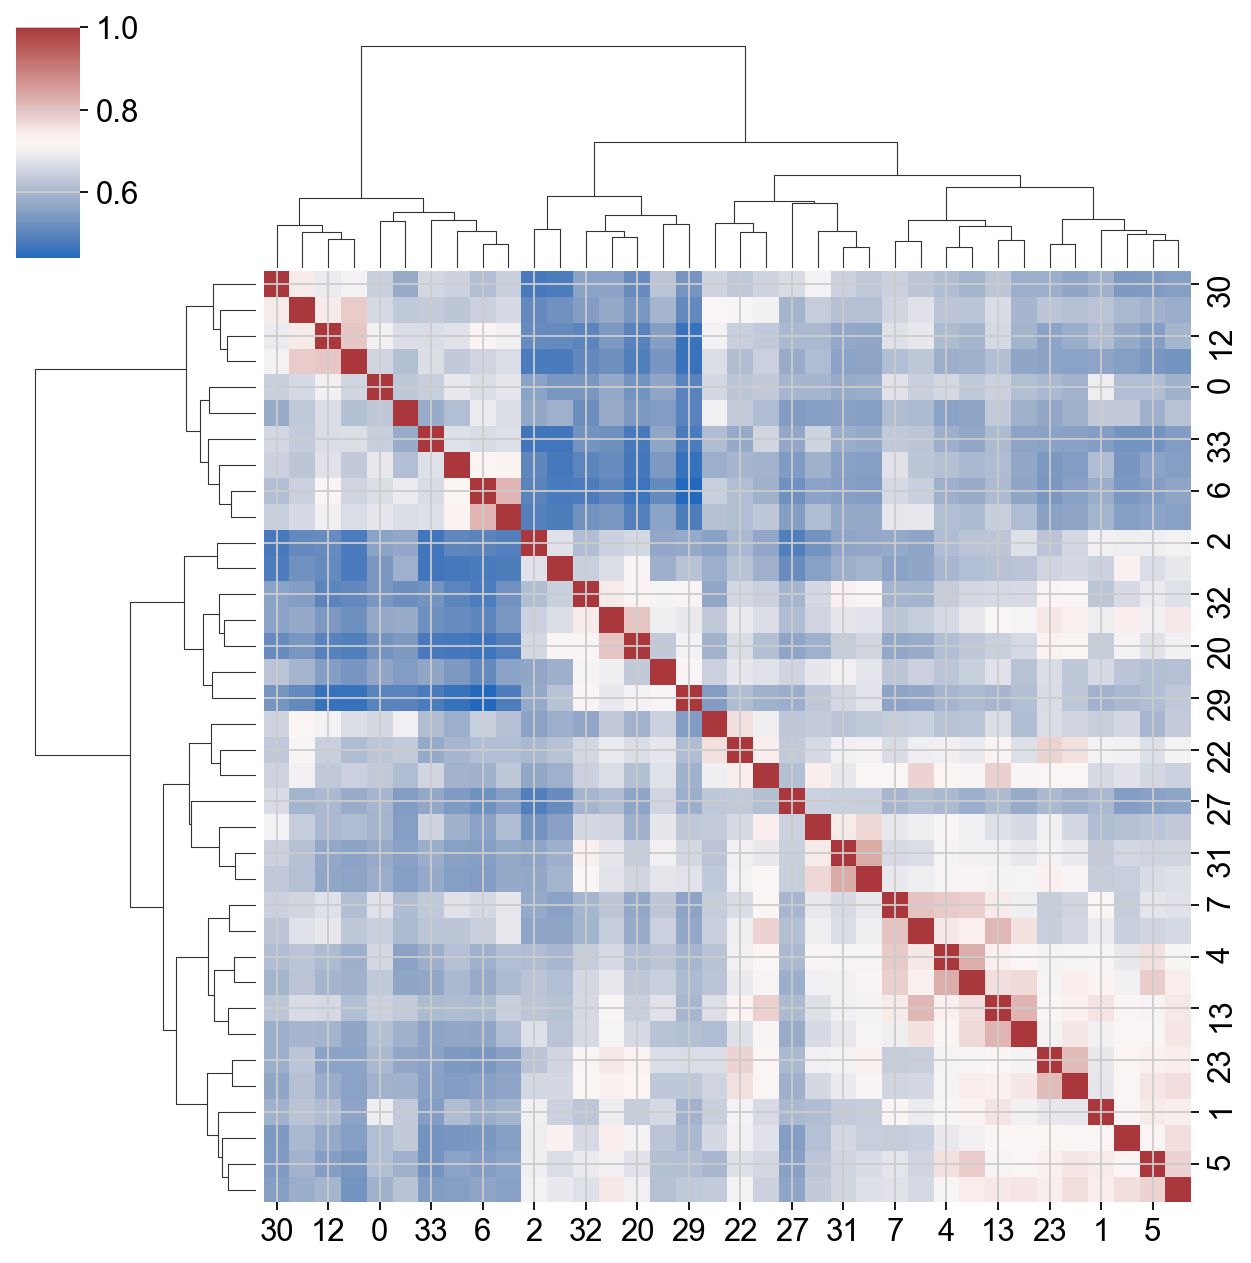

In [26]:
clustermap = sns.clustermap(
    cooc_corr_matrix,
    method='ward', metric='euclidean',
    figsize=(8,8), 
    cmap='vlag'
)

In [ ]:
# linked = clustermap.dendrogram_row.linkage
# cut_off_distance = 0.43
# dendrogram(
#     linked,
#     orientation='top',
#     distance_sort='descending',
#     color_threshold = cut_off_distance,
#     show_leaf_counts=True,
# )
# plt.ylim([0,3.5])
# plt.axhline(y=cut_off_distance, color='r', linestyle='--', linewidth=2, label=f'Cut-off at Distance = {cut_off_distance}')
# plt.legend(fontsize=10)
# plt.grid(axis='y', linestyle=':', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [ ]:
# cooc_cluster_labels = fcluster(linked, t=cut_off_distance, criterion='distance')
# # Find the unique cluster labels
# unique_labels = np.unique(cooc_cluster_labels)
# averaged_rows = []
# for label in unique_labels:
#     row_indices = np.where(cooc_cluster_labels == label)[0]
#     cluster_rows = condensed_cooc_matrix_all[row_indices, :]
#     averaged_row = np.mean(cluster_rows, axis=0)
#     averaged_rows.append(averaged_row)

# updated_condensed_cooc_matrix_all = np.vstack(averaged_rows)
# mean_condensed_cooc_matrix = np.mean(updated_condensed_cooc_matrix_all, axis=0)
# mean_cooc_matrix = mean_condensed_cooc_matrix.reshape([n_cells, n_cells])
# distance_matrix = 1 - mean_cooc_matrix
# sparse_cooc_matrix = csr_matrix(mean_cooc_matrix)

In [27]:
mean_condensed_cooc_matrix = np.mean(condensed_cooc_matrix_all,axis=0)
mean_cooc_matrix = mean_condensed_cooc_matrix.reshape([n_cells, n_cells])
distance_matrix = 1 - mean_cooc_matrix
sparse_cooc_matrix = csr_matrix(mean_cooc_matrix)

list1 = adata.obs.target_contrast_gene_name.values
list2 = adata.obs.culture_condition.values
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
mean_cooc_matrix_df = pd.DataFrame(data=mean_cooc_matrix,
                                   index=ind,
                                   columns=ind)

In [ ]:
clustermap = sns.clustermap(
    mean_cooc_matrix,
    method='ward', metric='euclidean',
    figsize=(8,8), 
    cmap='vlag'
)

In [29]:
sc.tl.leiden(adata, resolution=10, adjacency=sparse_cooc_matrix, key_added='leiden', random_state=42)
adata.obs['leiden'] = adata.obs['leiden'].astype(int)
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

In [30]:
cut_off_distance = 10
linked = linkage(distance_matrix, method='ward')
#linked = clustermap.dendrogram_row.linkage
final_labels = fcluster(linked, t=cut_off_distance, criterion='distance')
adata.obs['hierarchical'] = final_labels
adata.obs['hierarchical'] = adata.obs['hierarchical'].astype('category')

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_49668/2780834138.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='ward')


In [31]:
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=5,
                            min_samples=1,
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix)
final_labels = clusterer.labels_
adata.obs['hdbscan'] = final_labels
adata.obs['hdbscan'] = adata.obs['hdbscan'].astype('category')

In [ ]:
adata[adata.obs.target_contrast_gene_name.str.startswith(('SMG', 'DPH', 'TSC', 'ELP', 'MED12', 'TAF5L'))].obs.sort_values(by='target_contrast_gene_name')

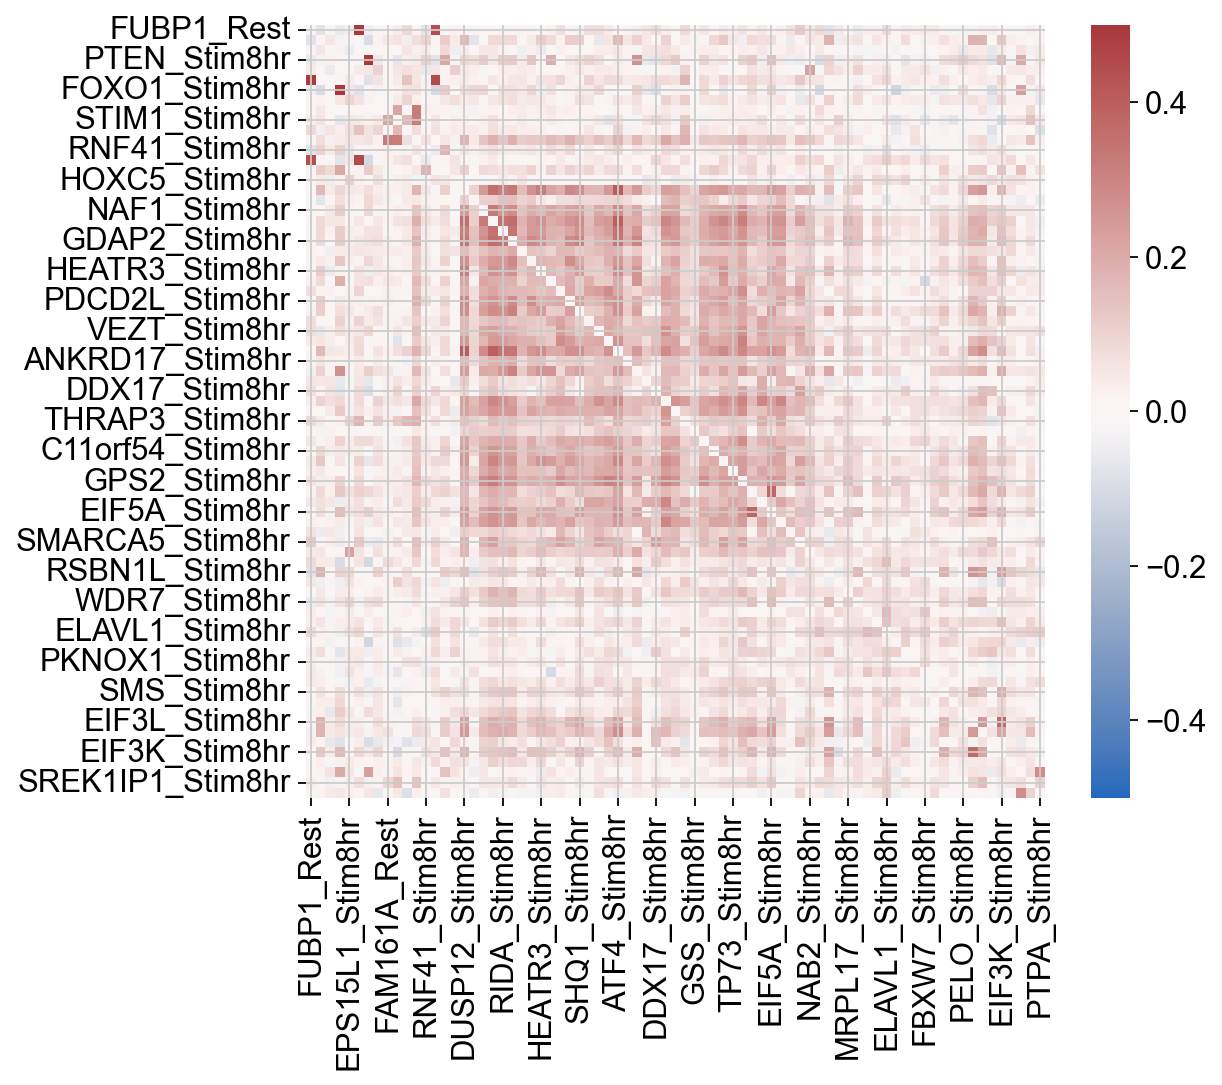

In [469]:
fig, ax = plt.subplots(figsize=(8,7))
cluster_label = 'hierarchical'
j = 44
data = adata[adata.obs[cluster_label]==j].X
list1 = adata[adata.obs[cluster_label]==j].obs.target_contrast_gene_name.values.tolist()
list2 = adata[adata.obs[cluster_label]==j].obs.culture_condition.values.tolist()
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
for i in range(j,48):
    data = np.concatenate([data, adata[adata.obs[cluster_label]==i+1].X])
    list1 = adata[adata.obs[cluster_label]==i+1].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata.obs[cluster_label]==i+1].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
test = pd.DataFrame(data=data,
                    index=ind,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax)
plt.tight_layout()

### Filter out low quality hdbscan clusters

In [89]:
np.max(adata.obs['hdbscan'].astype(int))

232

In [670]:
num_of_cluster = np.max(adata.obs['hdbscan'].astype(int))+1
corr = np.zeros(num_of_cluster)
cluster_size = np.zeros(num_of_cluster)
cluster_gene_size = np.zeros(num_of_cluster)
cluster_member = []
for i in range(len(corr)):
    list1 = adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    test = pd.DataFrame(data=adata[adata.obs['hdbscan']==i].layers['zscore'],
                        index=[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)],
                        columns=adata.var.gene_name)
    test2 = test.T.corr()
    np.fill_diagonal(test2.values, 0)
    corr[i] = np.mean(test2)
    cluster_size[i] = len(test)
    cluster_gene_size[i] = len(adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name.unique())
    cluster_member.append(adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name.unique().tolist())

cluster_df = pd.DataFrame({'cluster': np.arange(0, num_of_cluster, 1),
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

In [671]:
cluster_df

,cluster,intracluster_corr,cluster_size,cluster_gene_size,cluster_member
0,0,0.387359,21.0,8.0,"[SLC24A1, ARID5B, INTS13, C7orf26, FGFR1OP2, I..."
1,1,0.335780,6.0,2.0,"[RFX1, FOXN2]"
2,2,0.319344,9.0,3.0,"[PAGR1, STAG2, PAXIP1]"
3,3,0.269702,36.0,13.0,"[CTU2, ELP4, MOCS3, ELP3, SLC39A6, ELP5, ELP1,..."
4,4,0.264258,7.0,6.0,"[DPH6, DNAJC24, TPT1, TTC4, DPH1, DPH5]"
...,...,...,...,...,...
228,228,0.353323,32.0,32.0,"[PAPSS1, PPP1R13L, EXT2, NFE2L1, CIT, SRPK1, P..."
229,229,0.190654,8.0,8.0,"[PFKM, ZRSR2, FAM209B, TNFAIP3, VAMP5, ARID1A,..."
230,230,0.147525,14.0,14.0,"[SGCB, RABGEF1, EMX1, LTBP4, PDCL, ZBED6, NPC1..."
231,231,0.208895,7.0,7.0,"[ANP32B, EDRF1, NAA40, RBP5, ICK, C18orf25, WD..."


In [672]:
adata_final = adata.copy()
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(np.where(cluster_df.intracluster_corr<0.18)[0]), 'hdbscan'] = -1
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(np.where(cluster_gene_size<=3)[0]), 'hdbscan'] = -1
adata_final.obs['hdbscan'] = adata_final.obs['hdbscan'].astype('category')
adata_final = adata_final[adata_final.obs.hdbscan!=-1].copy()

In [673]:
adata_final.obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,leiden,hierarchical,hdbscan
ENSG00000104368_Stim8hr,PLAT,Stim8hr,ENSG00000104368,0,411.0,2,45,76
ENSG00000128607_Stim8hr,KLHDC10,Stim8hr,ENSG00000128607,0,1257.0,19,95,77
ENSG00000163600_Stim8hr,ICOS,Stim8hr,ENSG00000163600,0,658.0,19,95,77
ENSG00000168876_Stim8hr,ANKRD49,Stim8hr,ENSG00000168876,0,228.0,6,37,193
ENSG00000174177_Stim8hr,CTU2,Stim8hr,ENSG00000174177,0,500.0,27,106,3
...,...,...,...,...,...,...,...,...
ENSG00000073584_Rest,SMARCE1,Rest,ENSG00000073584,680,149.0,12,97,80
ENSG00000134323_Rest,MYCN,Rest,ENSG00000134323,680,924.0,17,78,93
ENSG00000157426_Rest,AASDH,Rest,ENSG00000157426,680,651.0,28,29,219
ENSG00000162377_Rest,COA7,Rest,ENSG00000162377,680,464.0,17,78,93


In [674]:
len(adata_final.obs['hdbscan'].unique())

114

In [675]:
adata_final.obs.target_contrast_gene_name.unique()

['PLAT', 'KLHDC10', 'ICOS', 'ANKRD49', 'CTU2', ..., 'DGKH', 'KAT2B', 'VPS8', 'TRMT6', 'ARL1']
Length: 1751
Categories (1751, object): ['A2M', 'AAMDC', 'AASDH', 'ABCA3', ..., 'ZSCAN25', 'ZSWIM4', 'ZSWIM9', 'ZW10']

In [50]:
import gseapy
from gseapy import Msigdb
from gseapy import barplot, dotplot

msig = Msigdb()
kegg_gene_sets = msig.get_gmt(category= 'c2.cp.kegg_legacy', dbver="2025.1.Hs")
reactome_gene_sets = msig.get_gmt(category= 'c2.cp.reactome', dbver="2025.1.Hs")

In [169]:
stringdb_df

,#string_taxon_id_x,cluster_id,protein_id,#string_protein_id,preferred_name,protein_size,annotation,#string_taxon_id_y,cluster_size,best_described_by
0,9606,CL:39184,9606.ENSP00000473493,9606.ENSP00000473493,MAGEB5,275,Melanoma-associated antigen B5; MAGE family me...,9606,7,"mixed, incl. Protein FAM81, and Bacterial Ig-l..."
1,9606,CL:39184,9606.ENSP00000288228,9606.ENSP00000288228,FAM81A,368,Protein FAM81A; Family with sequence similarit...,9606,7,"mixed, incl. Protein FAM81, and Bacterial Ig-l..."
2,9606,CL:39184,9606.ENSP00000344865,9606.ENSP00000344865,C9orf153,95,Uncharacterized protein C9orf153; Chromosome 9...,9606,7,"mixed, incl. Protein FAM81, and Bacterial Ig-l..."
3,9606,CL:39184,9606.ENSP00000432011,9606.ENSP00000432011,OR52B2,323,Olfactory receptor 52B2; Odorant receptor; Bel...,9606,7,"mixed, incl. Protein FAM81, and Bacterial Ig-l..."
4,9606,CL:39184,9606.ENSP00000357547,9606.ENSP00000357547,NUP210L,1888,Nuclear pore membrane glycoprotein 210-like; N...,9606,7,"mixed, incl. Protein FAM81, and Bacterial Ig-l..."
...,...,...,...,...,...,...,...,...,...,...
1270881,9606,CL:170,9606.ENSP00000294189,9606.ENSP00000294189,RPL29,159,60S ribosomal protein L29; Component of the la...,9606,24,Cytoplasmic ribosomal proteins
1270882,9606,CL:170,9606.ENSP00000375632,9606.ENSP00000375632,RPS9,194,Ribosomal protein S9.,9606,24,Cytoplasmic ribosomal proteins
1270883,9606,CL:170,9606.ENSP00000379339,9606.ENSP00000379339,RPS29,67,Ribosomal protein S29.,9606,24,Cytoplasmic ribosomal proteins
1270884,9606,CL:170,9606.ENSP00000367806,9606.ENSP00000367806,RPS16,152,Ribosomal protein S16.,9606,24,Cytoplasmic ribosomal proteins


In [39]:
corum_df = pd.read_csv('../../../RZAnalysisCodes/results/CORUM/corum_humanComplexes.txt', delimiter='\t', index_col='complex_id')
stringdb = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.clusters.proteins.v12.0.txt.gz', delimiter='\t', compression='gzip')
protein_info = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.protein.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
cluster_info = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.clusters.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
stringdb_df = pd.merge(stringdb, protein_info, left_on='protein_id', right_on='#string_protein_id')
stringdb_df = pd.merge(stringdb_df, cluster_info, left_on='cluster_id', right_on='cluster_id')
stringdb_df = stringdb_df[stringdb_df.cluster_size<1000].copy()

corum_complexes = {}
for _, row in corum_df.iterrows():
    complex_name = row['complex_name']
    subunits = set(row['subunits_gene_name'].split(';'))
    corum_complexes[complex_name] = subunits

stringdb_complexes = {}
for cluster_id in stringdb_df.cluster_id.unique():
    stringdb_complexes[cluster_id] = set(stringdb_df[stringdb_df.cluster_id==cluster_id].preferred_name)

In [282]:
def assess_complex_enrichment(adata, complexes, cluster_label):
    """
    Assess pathway/complex enrichment
    """
    de_genes_per_cluster = {}
    leiden_clusters = adata.obs[cluster_label].unique()
    for cluster in leiden_clusters:
        cluster_genes = adata[adata.obs[cluster_label] == cluster].obs.target_contrast_gene_name
        de_genes_per_cluster[cluster] = set(cluster_genes)
    
    N = len(adata)
    
    best_result = []
    all_result = []
    for cluster, de_genes in de_genes_per_cluster.items():
        n = len(de_genes)
        best_result_for_cluster = None # Initialize a variable to track the best result for this cluster
        for complex_name, subunits in complexes.items():
            K = len(subunits)
            # Find the overlap between DE genes and complex subunits
            overlap = de_genes.intersection(subunits)
            k = len(overlap)
            
            # Calculate the p-value
            if n > 0 and K > 0: # Avoid division by zero or trivial cases
                pval = hypergeom.sf(k - 1, N, K, n) # sf is survival function
                
                # Adjust for multiple testing (e.g., using Benjamini-Hochberg)
                # This is a crucial step to avoid false positives
                # Store raw p-values and correct later
                current_result = {
                    'cluster': cluster,
                    'complex': complex_name,
                    'overlap_genes': list(overlap),
                    'overlap_fraction': len(overlap)/n,
                    'raw_p_value': pval,
                    'complex_size': K
                }
                
                if (best_result_for_cluster is None) or (pval < best_result_for_cluster['raw_p_value']):
                    best_result_for_cluster = current_result
                if pval < 5e-2:
                    all_result.append(current_result)
        
        if best_result_for_cluster is not None:
            if best_result_for_cluster['raw_p_value']<1:
                best_result.append(best_result_for_cluster)
    
    # Convert results to a DataFrame for easy viewing
    best_result_df = pd.DataFrame(best_result)
    best_result_df = best_result_df.sort_values(by='cluster').reset_index(drop=True)
    all_result_df = pd.DataFrame(all_result)
    all_result_df = all_result_df.sort_values(by='cluster').reset_index(drop=True)

    return all_result_df, best_result_df

In [676]:
# Corum enrichment
corum_enrichment_all, corum_enrichment_best = assess_complex_enrichment(adata_final, corum_complexes, 'hdbscan')
# STRINGDB enrichment
stringdb_enrichment_all, stringdb_enrichment_best = assess_complex_enrichment(adata_final, stringdb_complexes, 'hdbscan')
stringdb_enrichment_all = pd.merge(stringdb_enrichment_all, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
stringdb_enrichment_all = stringdb_enrichment_all.drop(columns=['cluster_id'])
stringdb_enrichment_best = pd.merge(stringdb_enrichment_best, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
stringdb_enrichment_best = stringdb_enrichment_best.drop(columns=['cluster_id'])
# KEGG enrichment
kegg_enrichment_all, kegg_enrichment_best = assess_complex_enrichment(adata_final, kegg_gene_sets, 'hdbscan')
# Reactome enrichment
reactome_enrichment_all, reactome_enrichment_best = assess_complex_enrichment(adata_final, reactome_gene_sets, 'hdbscan')

# Also checking inter-cluster overlap
gene_grouping = {}
for cluster in adata_final.obs.hdbscan.unique():
    gene_grouping[cluster] = set(adata[adata.obs['hdbscan']==cluster].obs.target_contrast_gene_name)

intercluster_enrichment_all, _ = assess_complex_enrichment(adata_final, gene_grouping, 'hdbscan')
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.cluster!=intercluster_enrichment_all.complex].copy()
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.raw_p_value<1e-2].copy()
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.overlap_fraction>=0.2].copy()
intercluster_enrichment_summary = {}

for cluster in intercluster_enrichment_all.cluster.unique():
    intercluster_enrichment_summary[cluster] = set(intercluster_enrichment_all[intercluster_enrichment_all.cluster==cluster].complex)

intercluster_enrichment_summary_df = pd.DataFrame(intercluster_enrichment_summary.items(), columns=['cluster', 'related_cluster'])

# Summarize results
enrichment_df1 = pd.merge(corum_enrichment_best, stringdb_enrichment_best, on='cluster', how='outer', suffixes=('_corum', '_stringdb'))
enrichment_df2 = pd.merge(kegg_enrichment_best, reactome_enrichment_best, on='cluster', how='outer', suffixes=('_kegg', '_reactome'))
enrichment_df = pd.merge(enrichment_df1, enrichment_df2, on='cluster', how='outer')
enrichment_df = pd.merge(enrichment_df, cluster_df, on='cluster', how='inner')
enrichment_df = pd.merge(enrichment_df, intercluster_enrichment_summary_df, on='cluster', how='outer')

# Add timepoint information
cluster_member_with_condition = []
for index, row in enrichment_df.iterrows():
    list1 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.target_contrast_gene_name.tolist()
    list2 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.culture_condition.tolist()
    cluster_member_with_condition.append([f"{item1}_{item2}" for item1, item2 in zip(list1, list2)])
    enrichment_df.loc[index, 'rest_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Rest')])
    enrichment_df.loc[index, 'stim8hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim8hr')])
    enrichment_df.loc[index, 'stim48hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim48hr')])
    
enrichment_df['cluster_member_with_condition'] = cluster_member_with_condition

In [677]:
enrichment_df.to_parquet('results/clustering_nde30ntotal75.parquet')
enrichment_df.to_csv('results/clustering_nde30ntotal75.csv')
corum_enrichment_all.to_parquet('results/corum_enrichment_nde30ntotal75.parquet')
corum_enrichment_all.to_csv('results/corum_enrichment_nde30ntotal75.csv')
stringdb_enrichment_all.to_parquet('results/stringdb_enrichment_nde30ntotal75.parquet')
stringdb_enrichment_all.to_csv('results/stringdb_enrichment_nde30ntotal75.csv')
kegg_enrichment_all.to_parquet('results/kegg_enrichment_nde30ntotal75.parquet')
kegg_enrichment_all.to_csv('results/kegg_enrichment_nde30ntotal75.csv')
reactome_enrichment_all.to_parquet('results/reactome_enrichment_nde30ntotal75.parquet')
reactome_enrichment_all.to_csv('results/reactome_enrichment_nde30ntotal75.csv')

In [679]:
adata_final.write_h5ad('../../../RZAnalysisCodes/results/nde30ntotal75_clustering.h5ad')

In [ ]:
enrichment_df

In [703]:
set(intercluster_enrichment_all.loc[51, 'overlap_genes']) & set(intercluster_enrichment_all.loc[44, 'overlap_genes'])

{'DCAKD',
 'EFHD2',
 'FBXL3',
 'FHL1',
 'HIST1H2BI',
 'HSDL2',
 'IFFO2',
 'PCBP2',
 'ZMAT1'}

In [1]:
print(intercluster_enrichment_all.loc[245, 'overlap_genes'])

NameError: name 'intercluster_enrichment_all' is not defined

In [690]:
intercluster_enrichment_all

,cluster,complex,overlap_genes,overlap_fraction,raw_p_value,complex_size
4,4,6,"[DPH6, DPH1, TPT1, DPH5, DNAJC24]",0.833333,3.117919e-14,6
5,4,5,"[TTC4, DPH1, TPT1, DPH5, DNAJC24]",0.833333,3.117919e-14,6
6,5,4,"[TTC4, DPH1, TPT1, DPH5, DNAJC24]",0.833333,3.117919e-14,6
8,5,6,"[DPH1, TPT1, DPH2, DPH5, DNAJC24]",0.833333,3.117919e-14,6
9,6,5,"[DPH1, TPT1, DPH2, DPH5, DNAJC24]",0.833333,3.117919e-14,6
10,6,4,"[DPH6, DPH1, TPT1, DPH5, DNAJC24]",0.833333,3.117919e-14,6
13,10,93,"[MRPL10, SCO2, COA7, CYC1, COX6B1, TFAM, VARS2...",0.672727,5.434316e-105,84
14,10,57,"[COX15, MRPS5, MTERF3, TFAM, VARS2, MRPL49, NS...",0.490909,1.547629e-42,146
16,10,58,"[COQ6, SCO2, COA7, CYC1, COX6C, MRPS9, COA3, C...",0.227273,3.621986e-33,28
21,16,19,"[LAMTOR3, WDR24, RPTOR, LAMTOR4, TMEM214]",0.454545,5.005670e-11,9


In [558]:
set(adata_final[adata_final.obs.hdbscan==77].obs.target_contrast_gene_name) & set(adata_final[adata_final.obs.hdbscan==92].obs.target_contrast_gene_name) & (set(adata_final[adata_final.obs.hdbscan==131].obs.target_contrast_gene_name)|set(adata_final[adata_final.obs.hdbscan==132].obs.target_contrast_gene_name))

{'ADAM19',
 'ALKBH2',
 'CACHD1',
 'HSD17B13',
 'MFHAS1',
 'PDLIM2',
 'PXMP4',
 'RAB11FIP1',
 'RASGRP1'}

In [699]:
adata[adata.obs.target_contrast_gene_name.isin(['PIK3CD', 'MLST8', 'RICTOR', 'MAPKAP1', 'PDPK1'])].obs.sort_values(by='target_contrast_gene_name')

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,leiden,hierarchical,hdbscan
ENSG00000119487_Rest,MAPKAP1,Rest,ENSG00000119487,290,414.0,10,23,223
ENSG00000119487_Stim48hr,MAPKAP1,Stim48hr,ENSG00000119487,468,352.0,15,59,199
ENSG00000167965_Stim8hr,MLST8,Stim8hr,ENSG00000167965,485,307.0,16,141,177
ENSG00000167965_Rest,MLST8,Rest,ENSG00000167965,502,369.0,10,23,230
ENSG00000167965_Stim48hr,MLST8,Stim48hr,ENSG00000167965,597,258.0,15,59,199
ENSG00000140992_Stim48hr,PDPK1,Stim48hr,ENSG00000140992,102,111.0,15,59,199
ENSG00000140992_Rest,PDPK1,Rest,ENSG00000140992,437,158.0,11,32,200
ENSG00000140992_Stim8hr,PDPK1,Stim8hr,ENSG00000140992,440,130.0,16,141,-1
ENSG00000171608_Stim48hr,PIK3CD,Stim48hr,ENSG00000171608,462,470.0,15,59,199
ENSG00000164327_Rest,RICTOR,Rest,ENSG00000164327,126,781.0,10,23,-1


In [700]:
de_counts[de_counts.target_name.isin(['PIK3CD', 'MLST8', 'RICTOR', 'MAPKAP1', 'PDPK1'])].sort_values(by='target_name')

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes
ENSG00000119487_Rest,ENSG00000119487,MAPKAP1,Rest,414.0,63,38,101
ENSG00000119487_Stim48hr,ENSG00000119487,MAPKAP1,Stim48hr,352.0,180,99,279
ENSG00000119487_Stim8hr,ENSG00000119487,MAPKAP1,Stim8hr,393.0,8,8,16
ENSG00000167965_Stim8hr,ENSG00000167965,MLST8,Stim8hr,307.0,54,80,134
ENSG00000167965_Rest,ENSG00000167965,MLST8,Rest,369.0,164,145,309
ENSG00000167965_Stim48hr,ENSG00000167965,MLST8,Stim48hr,258.0,314,272,586
ENSG00000140992_Stim48hr,ENSG00000140992,PDPK1,Stim48hr,111.0,192,131,323
ENSG00000140992_Rest,ENSG00000140992,PDPK1,Rest,158.0,123,64,187
ENSG00000140992_Stim8hr,ENSG00000140992,PDPK1,Stim8hr,130.0,47,22,69
ENSG00000171608_Stim48hr,ENSG00000171608,PIK3CD,Stim48hr,470.0,14,20,34


In [560]:
adata[adata.obs.target_contrast_gene_name.str.startswith('FAN')].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,leiden,hierarchical,hdbscan
ENSG00000112039_Stim48hr,FANCE,Stim48hr,ENSG00000112039,35,214.0,18,88,149
ENSG00000183161_Stim48hr,FANCF,Stim48hr,ENSG00000183161,71,277.0,48,15,121
ENSG00000187790_Rest,FANCM,Rest,ENSG00000187790,83,501.0,8,19,232
ENSG00000181544_Rest,FANCB,Rest,ENSG00000181544,117,393.0,8,19,232
ENSG00000115392_Stim48hr,FANCL,Stim48hr,ENSG00000115392,121,127.0,51,15,115
ENSG00000183161_Rest,FANCF,Rest,ENSG00000183161,183,296.0,8,19,232
ENSG00000181544_Stim48hr,FANCB,Stim48hr,ENSG00000181544,235,353.0,51,15,115
ENSG00000115392_Rest,FANCL,Rest,ENSG00000115392,250,157.0,8,19,232
ENSG00000187741_Stim48hr,FANCA,Stim48hr,ENSG00000187741,282,360.0,18,15,121
ENSG00000112039_Rest,FANCE,Rest,ENSG00000112039,397,243.0,8,19,232


In [633]:
ind1 = np.where(adata.obs.index.isin(['ENSG00000181544_Stim8hr', 'ENSG00000187790_Stim8hr', 'ENSG00000112039_Stim8hr']))[0]
ind2 = np.where(adata.obs.index.isin(['ENSG00000084093_Stim8hr', 'ENSG00000126261_Stim8hr', 'ENSG00000197713_Stim8hr']))[0]
ind3 = np.where(adata.obs.index.isin(['ENSG00000106615_Rest', 'ENSG00000181754_Rest', 'ENSG00000105135_Rest']))[0]
ind = np.concatenate([ind1, ind2, ind3])
ind = np.concatenate([ind1, ind2])

ENSG00000181544_Stim8hr    0.229927
ENSG00000187790_Stim8hr    0.228583
ENSG00000112039_Stim8hr    0.226620
ENSG00000197713_Stim8hr    0.207617
ENSG00000084093_Stim8hr    0.138590
ENSG00000126261_Stim8hr    0.163671
dtype: float64


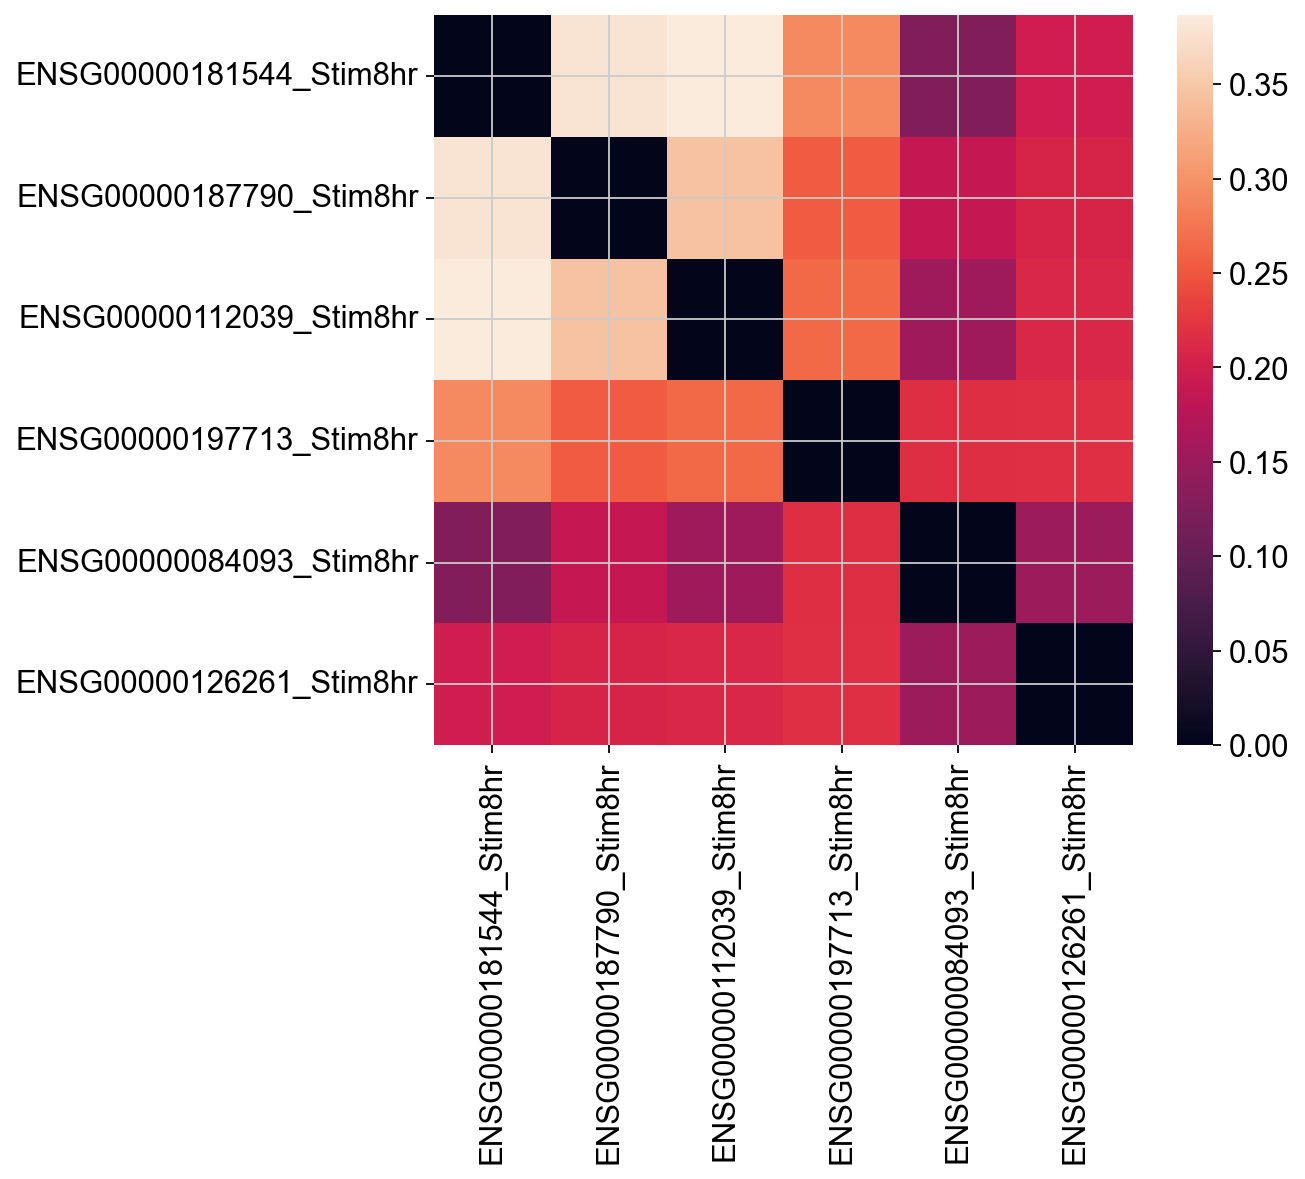

In [634]:
fig, ax = plt.subplots(figsize=(7,6))
test = pd.DataFrame(adata[ind,:].layers['zscore'].copy(),
                    index=adata[ind,:].obs.index,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())

In [638]:
cluster_df.iloc[196]

cluster                                                            196
correlation                                                   0.132266
cluster_size                                                      51.0
cluster_gene_size                                                 51.0
cluster_member       [XRCC2, STK11, RPE, PRKAR1A, REST, MFN2, SOCS4...
Name: 196, dtype: object

In [639]:
len(test2)

51

In [636]:
np.mean(test2)

0.2190102623292116

target_contrast_gene_name
XRCC2       0.155460
STK11       0.187877
RPE         0.145033
PRKAR1A     0.196557
REST        0.096093
MFN2        0.098684
SOCS4       0.133337
UBE2N       0.156684
UBA2        0.087478
MPP2        0.114244
ARPC1B      0.102885
LIG1        0.171957
NOP53       0.137614
CUL3        0.153088
BBS10       0.142966
RPL29       0.118924
DAXX        0.134098
CCS         0.160383
TIAF1       0.123710
ERCC4       0.173265
TMEM123     0.133618
MYB         0.124566
IPO9        0.109783
CHTF18      0.148957
RNASEH2A    0.107006
IFNGR1      0.082464
AKIRIN2     0.084143
UROS        0.135945
OTUB1       0.161529
UBE2T       0.131997
ZBTB7A      0.105865
SMAP2       0.161909
EIF2AK4     0.083367
TBCA        0.128584
VPS26B      0.148381
PPIL1       0.131701
FBRS        0.102919
OTUD1       0.162664
HOXB2       0.113378
FANCB       0.164285
FANCM       0.164143
ZFYVE21     0.082971
SRSF10      0.125804
SCAF11      0.092112
FANCE       0.156506
TBL1X       0.107938
RPUSD1  

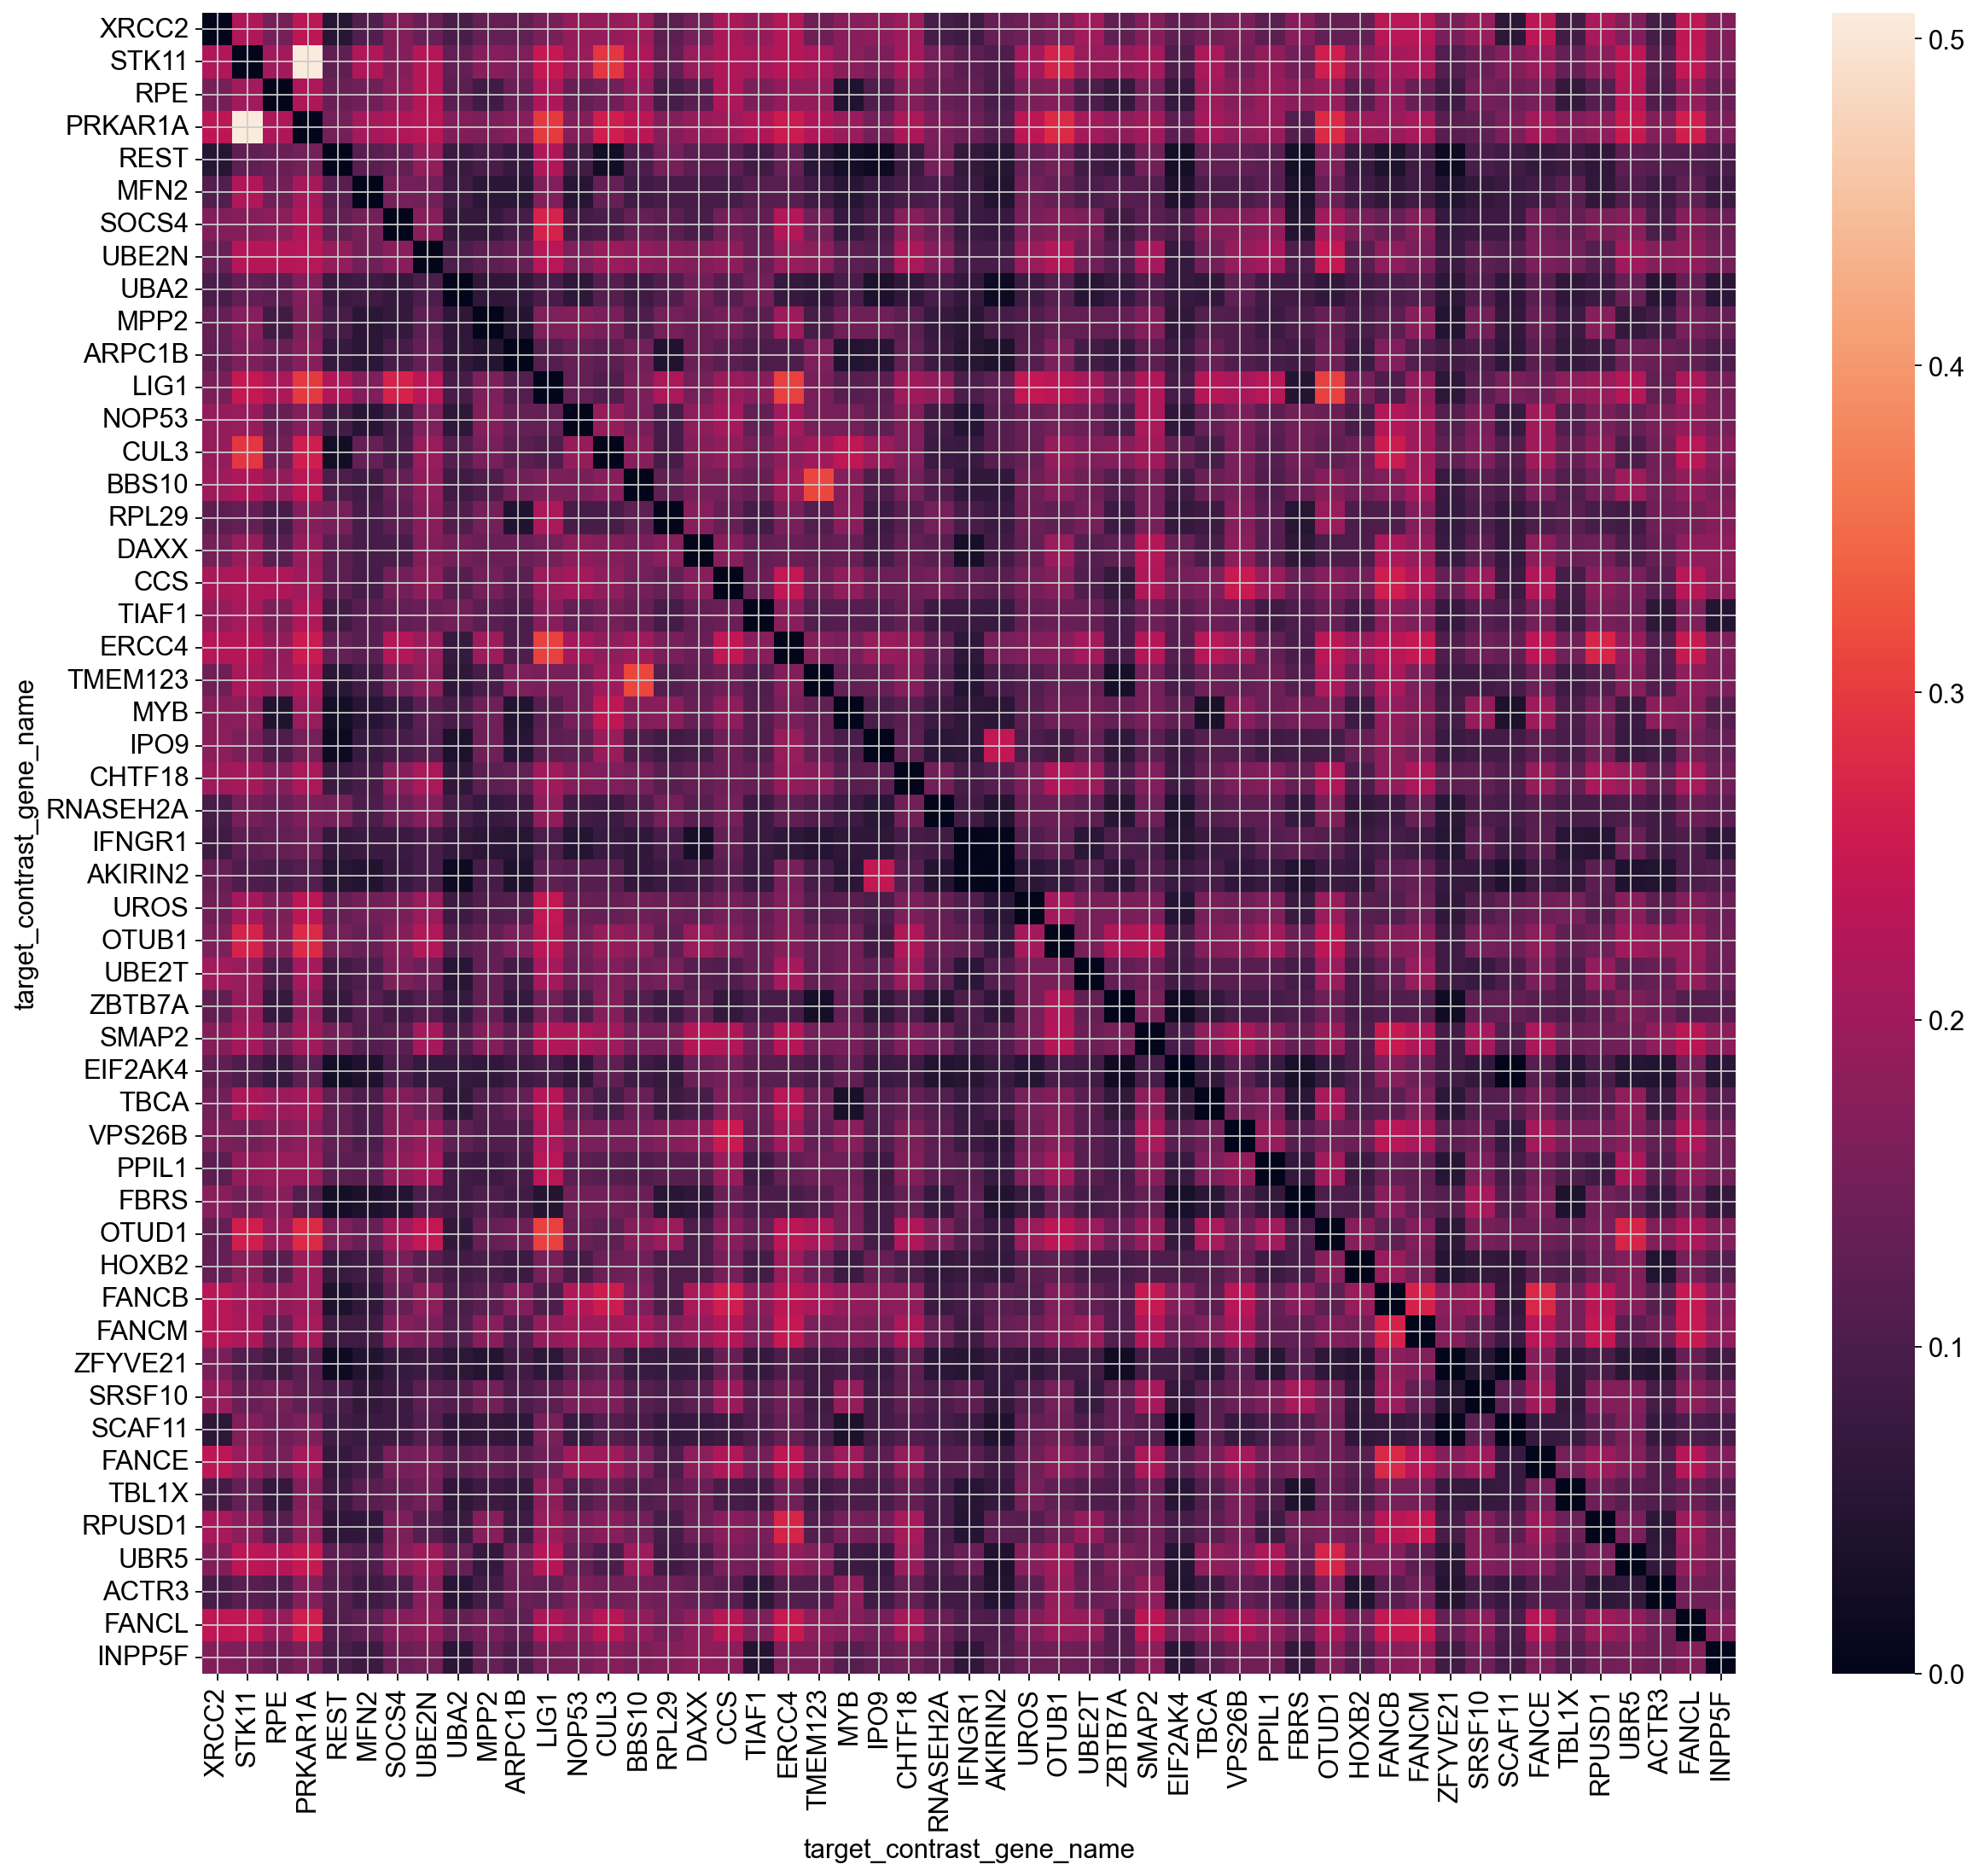

In [641]:
fig, ax = plt.subplots(figsize=(18,16))
test = pd.DataFrame(adata[adata.obs.hdbscan==196].X.copy(),
                    index=adata[adata.obs.hdbscan==196].obs.target_contrast_gene_name,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())

target_contrast_gene_name
XRCC2       0.251993
STK11       0.276370
RPE         0.239903
PRKAR1A     0.286010
REST        0.170421
MFN2        0.181922
SOCS4       0.220954
UBE2N       0.235484
UBA2        0.165897
MPP2        0.194984
ARPC1B      0.196420
LIG1        0.260427
NOP53       0.233821
CUL3        0.228241
BBS10       0.249525
RPL29       0.195119
DAXX        0.205384
CCS         0.258144
TIAF1       0.219291
ERCC4       0.263898
TMEM123     0.213682
MYB         0.206153
IPO9        0.186391
CHTF18      0.238871
RNASEH2A    0.188368
IFNGR1      0.167099
AKIRIN2     0.156660
UROS        0.234154
OTUB1       0.253307
UBE2T       0.211350
ZBTB7A      0.192541
SMAP2       0.251400
EIF2AK4     0.160848
TBCA        0.216539
VPS26B      0.248698
PPIL1       0.215955
FBRS        0.187264
OTUD1       0.252743
HOXB2       0.195839
FANCB       0.260649
FANCM       0.266563
ZFYVE21     0.168401
SRSF10      0.199740
SCAF11      0.173715
FANCE       0.252348
TBL1X       0.189730
RPUSD1  

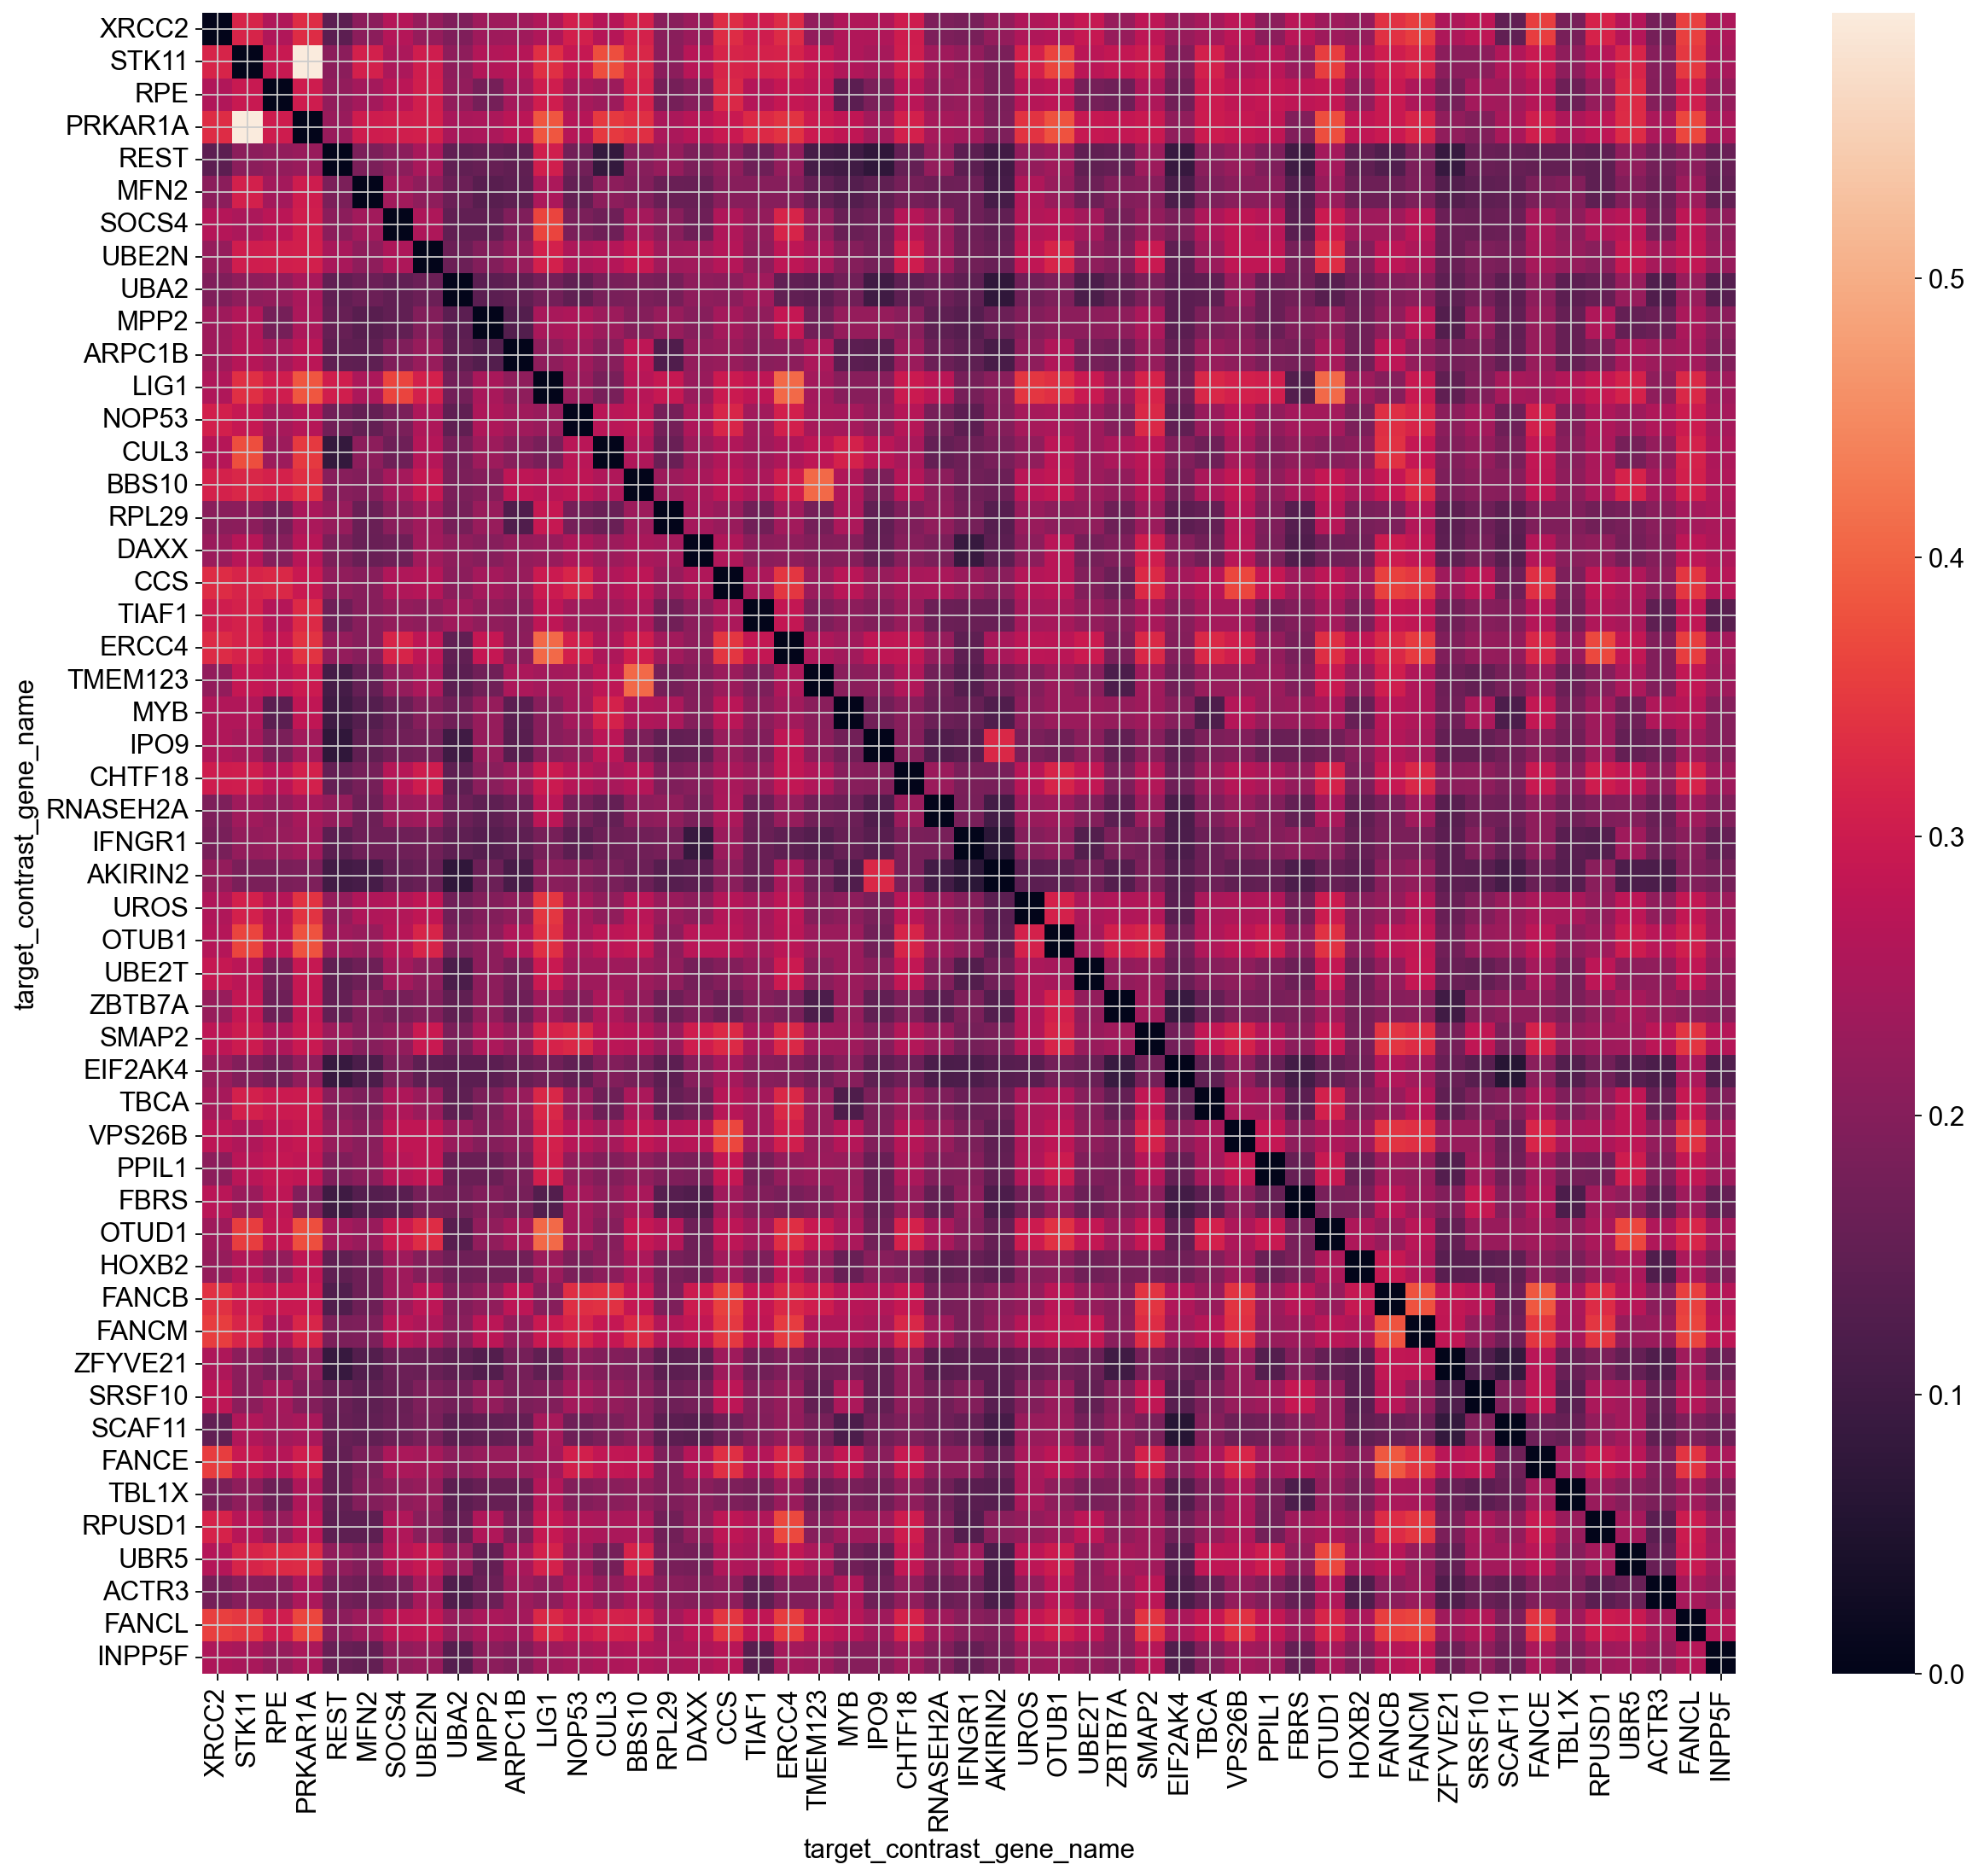

In [635]:
fig, ax = plt.subplots(figsize=(18,16))
test = pd.DataFrame(adata[adata.obs.hdbscan==196].layers['zscore'].copy(),
                    index=adata[adata.obs.hdbscan==196].obs.target_contrast_gene_name,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())

In [562]:
cluster_df.iloc[196]

cluster                                                            196
correlation                                                   0.132266
cluster_size                                                      51.0
cluster_gene_size                                                 51.0
cluster_member       [XRCC2, STK11, RPE, PRKAR1A, REST, MFN2, SOCS4...
Name: 196, dtype: object

In [600]:
adata[adata.obs.hdbscan==196].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,leiden,hierarchical,hdbscan
ENSG00000196584_Stim8hr,XRCC2,Stim8hr,ENSG00000196584,10,159.0,6,36,196
ENSG00000118046_Stim8hr,STK11,Stim8hr,ENSG00000118046,46,218.0,6,36,196
ENSG00000197713_Stim8hr,RPE,Stim8hr,ENSG00000197713,124,336.0,6,36,196
ENSG00000108946_Stim8hr,PRKAR1A,Stim8hr,ENSG00000108946,141,94.0,6,36,196
ENSG00000084093_Stim8hr,REST,Stim8hr,ENSG00000084093,146,91.0,6,36,196
ENSG00000116688_Stim8hr,MFN2,Stim8hr,ENSG00000116688,177,157.0,6,36,196
ENSG00000180008_Stim8hr,SOCS4,Stim8hr,ENSG00000180008,204,269.0,6,36,196
ENSG00000177889_Stim8hr,UBE2N,Stim8hr,ENSG00000177889,208,107.0,6,36,196
ENSG00000126261_Stim8hr,UBA2,Stim8hr,ENSG00000126261,219,77.0,6,36,196
ENSG00000108852_Stim8hr,MPP2,Stim8hr,ENSG00000108852,240,202.0,6,36,196


In [565]:
cluster_df[(cluster_df.correlation>0.1)&(cluster_df.correlation<=0.15)]

,cluster,correlation,cluster_size,cluster_gene_size,cluster_member
13,13,0.123188,7.0,3.0,"[CLASRP, CFAP20, C7orf55-LUC7L2]"
17,17,0.122135,9.0,5.0,"[KLHDC10, KDM2A, KMT2B, UBFD1, RAB2B]"
24,24,0.107716,7.0,5.0,"[NCOR1, C11orf68, CCNA2, HDAC3, RELL2]"
25,25,0.103608,12.0,7.0,"[MCTS1, DENR, GABPB1, BORCS8-MEF2B, CARNMT1, K..."
32,32,0.123476,5.0,3.0,"[PIGB, GPR137, PDIA3]"
39,39,0.108427,18.0,9.0,"[ZNF200, TENT5C, PCGF1, FAM208B, KDM5C, PCGF6,..."
45,45,0.138748,22.0,8.0,"[CDKN2AIP, RBM12, RPRD1B, UBE3D, WDR82, DNAAF2..."
50,50,0.137574,46.0,45.0,"[SMS, CNBP, NOP53, TRRAP, TSC22D2, ZNF607, ERF..."
66,66,0.134603,6.0,6.0,"[UBE2V2, STAT1, ZC3H12A, ZBTB21, MUS81, USF2]"
87,87,0.124352,11.0,11.0,"[CMTM7, LUZP6, GYPC, ERGIC3, FBXO32, DOP1B, CD..."


In [601]:
clustering_temp = clustering_summary

In [607]:
cluster1 = []
cluster2 = []
cluster_size = []
for i in range(len(clustering_temp)):
    cluster1.append(clustering_temp.loc[i, 'leiden_assignment'][ind1].tolist())
    cluster2.append(clustering_temp.loc[i, 'leiden_assignment'][ind2].tolist())
    cluster_temp = clustering_temp.loc[i, 'leiden_assignment'][ind1].tolist()[0]
    cluster_size.append(np.sum(clustering_temp.loc[i, 'leiden_assignment']==cluster_temp))
clustering_temp['cluster1'] = cluster1
clustering_temp['cluster2'] = cluster2
clustering_temp['FANCE_cluster_size'] = cluster_size

In [608]:
clustering_temp

,n_comp,n_neighbor,resolution,sil_score_raw,sil_score_pca,ch_score_raw,ch_score_pca,db_score_raw,db_score_pca,leiden_assignment,cluster1,cluster2,FANCE_cluster_size
0,75,15,2,0.016427,0.058987,22.958467,74.534779,4.435003,2.425253,"[8, 4, 20, 5, 2, 24, 7, 15, 7, 11, 13, 13, 21,...","[2, 2, 2]","[2, 2, 2]",277
1,75,15,3,0.011220,0.048698,18.423818,61.241145,4.489873,2.527932,"[6, 4, 32, 9, 3, 35, 5, 12, 5, 11, 23, 14, 17,...","[3, 3, 3]","[3, 3, 3]",220
2,75,15,4,0.008050,0.034090,15.956902,53.281551,4.475143,2.511294,"[43, 22, 34, 34, 9, 46, 1, 15, 1, 5, 35, 11, 3...","[9, 9, 9]","[9, 9, 9]",126
3,75,31,2,0.015017,0.051422,24.650208,77.349527,4.382809,2.379830,"[9, 3, 18, 18, 4, 19, 11, 14, 11, 6, 8, 8, 8, ...","[4, 4, 4]","[4, 4, 4]",319
4,75,31,3,0.014618,0.054336,21.010581,69.848063,4.568584,2.516332,"[5, 26, 23, 23, 4, 31, 7, 16, 7, 6, 37, 26, 14...","[4, 4, 4]","[4, 4, 4]",206
5,75,31,4,0.010993,0.045087,18.149377,61.555573,4.572742,2.514009,"[40, 23, 34, 34, 7, 32, 3, 13, 3, 4, 44, 14, 2...","[7, 7, 7]","[7, 7, 7]",163
6,75,63,2,0.013317,0.052116,28.603754,90.312897,4.508228,2.432423,"[7, 2, 17, 17, 3, 20, 11, 14, 11, 6, 13, 13, 9...","[3, 3, 3]","[3, 3, 3]",333
7,75,63,3,0.009088,0.036808,21.538062,69.695707,4.638048,2.506608,"[6, 16, 18, 18, 2, 27, 8, 14, 8, 7, 19, 19, 22...","[2, 2, 2]","[2, 2, 2]",252
8,75,63,4,0.010214,0.036046,19.760796,66.626909,4.680761,2.564799,"[6, 15, 28, 28, 5, 36, 7, 14, 7, 4, 18, 22, 34...","[5, 5, 5]","[5, 5, 5]",192
9,100,15,2,0.011034,0.045614,22.147139,66.326297,4.366449,2.502863,"[9, 3, 17, 6, 1, 24, 8, 14, 8, 5, 10, 10, 18, ...","[1, 1, 1]","[1, 1, 1]",335
